# 18.335 pset 1 solutions

## Problem 1: Floating point

As explained in the solutions, the smallest non-representable integer [Trefethen problem 13.2(c)] in IEEE double precision should be $2^{53}+1$.  Let's check $2^{53} + o$ for $o \in {-3,-2,...,3}$, by the simple expedient of comparing to integers (using a 64-bit integer type, `Int64`, such that these integers are represented exactly; note that `Int64` is the default integer type in Julia except on 32-bit systems):

In [2]:
β = Int64(2)  # make sure we are using 64-bit ints, even on 32-bit machines
p = 53
for o in -3:3
    i = β^p + o
    println("β^p + $o = $i exactly represented in Float64? ", i == Float64(i))
end

β^p + -3 = 9007199254740989 exactly represented in Float64? true
β^p + -2 = 9007199254740990 exactly represented in Float64? true
β^p + -1 = 9007199254740991 exactly represented in Float64? true
β^p + 0 = 9007199254740992 exactly represented in Float64? true
β^p + 1 = 9007199254740993 exactly represented in Float64? false
β^p + 2 = 9007199254740994 exactly represented in Float64? true
β^p + 3 = 9007199254740995 exactly represented in Float64? false


Notice that $2^{53}+2$ is exactly represented, because that is equal to $(2^{52}+1) \times 2$.

## Problem 2: Funny functions

### part (a)

Consider the following naive function to compute the $L_4$ norm $(|x|^4 + |y|^4))^{1/4}$ of $(x,y)$:

In [3]:
L4(x,y) = (abs(x)^4 + abs(y)^4)^(1/4)

L4 (generic function with 1 method)

We should have `L4(x,0)` give $|x|$, but for very small or very large `x` we get floating-point **underflow** or **overflow**, respectively.  In the default double precision (`Float64`):

In [4]:
L4(1e-100, 0)  # (1e-100)⁴ underflows to 0.0

0.0

In [5]:
L4(1e+100, 0)  # (1e+100)⁴ overflows to Inf

Inf

To eliminate this problem, we can simply compute $s = \max\{|x|,|y|\}$ and then pull out this scale factor, since in exact arithmetic $L_4(x,y) = s L_4(x/s,y/s)$ for any $s > 0$.  In this way, we avoid underflow/overflow in the leading-order term.  (If $|y|\ll |x|$ and $|y/x|^4$ underflows to zero, we don't care, because $1 \oplus |y/x|^4$ will round to `1.0` long before that point.)

In [12]:
function L4good(x,y)
    ax, ay = abs(x), abs(y)
    s = max(ax,ay)
    if s == 0
        return float(s) # don't divide by zero if x==y==0
    else
        return s * ((ax/s)^4 + (ay/s)^4)^(1/4)
    end
end
    

L4good (generic function with 1 method)

In [10]:
L4good(1e-100, 0)

1.0e-100

In [11]:
L4good(1e+100, 0)

1.0e100

In [13]:
L4good(0, 0)

0.0

Let's compute the maximum relative error (compared to `BigFloat`) for million random numbers with random magnitudes from $10^{-308}$ to $10^{+308}$:

In [14]:
maxerr = 0.0
for i = 1:10^6
    x = (rand() - 0.5) * 10.0^rand(-308:308)
    y = (rand() - 0.5) * 10.0^rand(-308:308)
    result = L4good(x,y)
    exact = L4good(big(x), big(y)) # in 256-bit precision by default
    maxerr = max(maxerr, Float64(abs(result - exact) / abs(exact)))
end
println("maximum relative err = ", maxerr, " = ", maxerr/eps(Float64), " ulps.")

maximum relative err = 1.336014039101445e-15 = 6.016872328659019 ulps.


Accurate to within 6 ulps, not too bad considering all the arithmetic required to take to the 4th power and then to the 1/4th power!

### part (b)

Now we are calculating:

In [15]:
cotdiff(x,y) = cot(x) - cot(x+y)

cotdiff (generic function with 1 method)

The problem with this naive implementation is that for $|y|\ll|x|$ we are subtracting two *nearly equal* quantities, and so we lose all of our significant digits:

In [16]:
cotdiff(1.0, 1e-20)

0.0

The correct answer here is:

In [17]:
cotdiff(big(1.0), big(1e-20))ε

1.412282927437391837141168489135572923149464055882223010816205368999992462784898e-20

How can we calculate this acccurately without resorting to extra precision?

One option would be to Taylor-expand around $y=0$ and analytically cancel the leading-order $\cot(x)$ term::
$$
\cot(x) - \cot(x+y) = y \csc^2(x) - y^2 \cot(x)\csc^2(x) + \frac{y^3}{3} \left[(\cos(2x)+2)\csc^4(x)\right] - O(y^4)
$$
We could then use something like:
```jl
function cotdiff_taylor(x,y)
    ε = ... some threshold ...
    if abs(y) < abs(x) * ε
         return y*csc(x)^2 + ... taylor series to some order ....
    else
        return cot(x) - cot(x+y)
    end
end
```
In some problems, you have no choice to do something like this, but it is a bit painful to decide on the threshold `ε` and the correct number of terms in the Taylor series in order to ensure close to machine precision everywhere.

Instead, since these are trigonometric functions, we can try to exploit angle-addition identities to re-arrange the formula so as to perform the cancellation *exactly*.  In particular, you can easily show that:
$$
\cot(x) - \cot(x+y) = \left[\cot(x+y) \cot(x) + 1\right] \tan(y)
$$
in which there is no delicate cancellation for $y \to 0$.

In [18]:
cotdiff_better(x,y) = (cot(x+y)*cot(x) + 1) * tan(y)

cotdiff_better (generic function with 1 method)

In [19]:
cotdiff_better(1.0, 1e-20)  # now this is accurate!

1.4122829274373917e-20

In [20]:
relerr(approx,exact) = Float64(abs(approx-exact) / abs(exact))

relerr(cotdiff_better(1.0, 1e-20), cotdiff(big(1.0), big(1e-20)))

6.738018671929406e-17

Now it is accurate to machine precision for this example!  

We can see that relative error (in ulps) is around 1ulp or better for more magnitudes, but for very small $|y|$ we need to increase our `BigFloat` precision:

In [24]:
maxerr = 0.0
setprecision(BigFloat, 2000) do
    for y in 10.0 .^ (-100:1)
       global maxerr = max(maxerr, relerr(cotdiff_better(1.0, y), cotdiff(big(1.0), big(y))))
    end
end
println("maximum relative error is $maxerr = ", maxerr/eps(Float64), " ulps")

maximum relative error is 2.2789719735542174e-16 = 1.0263577330886577 ulps


## Problem 3: Newtonish methods

Suppose we are trying to find a root $f(x)=0$ and we are given ways to compute $f$, $f'$, and $f''$.   We will design an algorithm to take advantage of this, and apply it to $f(x)=x^3-1$.

### part (a)

We approximate $f(x)$ by the first two terms in the Taylor series (assuming $f$ is analytic):
$$
f(x - \delta) \approx f(x) - \delta f'(x) + \frac{\delta^2}{2} f''(x) = 0
$$
and set the right-hand side to zero to find an approximate root.  Solving the quadratic equation and eliding the $(x)$ arguments, we obtain an approximate step to the root:
$$
\delta = \frac{f' \pm \sqrt{f'^2 - 2ff''}}{f''}
$$
Close to the root, $f$ is small and therefore the discriminant will be positive and we will get real roots.   Say $f' > 0$.  Then we want the minus root of this quadratic, because we want the *nearest* root (the smallest $\delta$): that is where the quadratic approximation is most accurate.  But this will run into cancellation errors for subtracting two nearly equal quantities, so we rewrite the desired solution as:
$$
\delta = \frac{2f}{f' + \sqrt{f'^2 - 2ff''}}
$$
Conversely, if $f' < 0$, then we need the other root $2f / (f' - \sqrt{f'^2 - 2ff''})$.  That is, we want to copy the sign of $f'$ to the square root, which is easily done with the Julia `copysign` function.

If we are not close to the root, so that the discriminant is negative, we will just take an ordinary Newton step $\delta = f/f'$.  Notice that this is also approximately the step we take when $f$ is very small.  

Here is code that implements this idea:

In [25]:
# take n Newtonish steps starting at x, given functions f(x),f′(x),f″(x) 
function newtonish(f,f′,f″, x, n)
    for i = 1:n
        fx = f(x)
        f′x = f′(x)
        f″x = f″(x)
        discrim = f′x^2 - 2*fx*f″x
        δ = discrim < 0 ? fx/f′x : 2fx / (f′x + copysign(sqrt(discrim), f′x))
        x = x - δ
    end
    return x
end

newtonish (generic function with 1 method)

### part (b)

Let $x$ be the exact root, and $x_n = x(1 + \delta_n)$ be the Newton-ish iterate.   As in class, we wish to analyze $\delta_{n+1}$ in terms of $\delta_n$, in the asymptotic regime where we are close to convergence ($|\delta_n| \ll 1$).  Taylor expanding $f$ around $x$, we obtain:
$$
f_n = f(x_n) = f'(x) x \delta_n + O(\delta_n^2) = x f'(x) \left[1  + O(\delta_n) \right] \delta_n
$$
or
$$\delta_n = \frac{f_n}{x f'(x)} \left[1 - O(\delta_n)\right].$$
This is useful because it relates the error in $x_n$ to the error in $f_n$.  Furthermore, the iterate $x_{n+1}$ is defined, above, to set the first two terms in the Taylor series for $f(x)$ to zero, which means that $f_{n+1} = O(\delta_n^3)$: the error in $f_{n+1}$ is dominated by the *cubic* term in the Taylor series.  Hence:
$$\delta_{n+1} = \frac{O(\delta_n^3)}{x f'(x)} \left[1 - O(\delta_n)\right] = O(\delta_n^3)$$
and we have **cubic convergence**.  The number of digits should roughly triple on each step.

Alternatively, we could explicitly plug the Taylor expansion of $f$ into our iteration formula from part (a), and then solve everything to lowest-order in $\delta_n$.   (Be careful: the iteration formula is in terms of $f$, $f'$, and $f''$ at $x_n$, *not* at the root $x$.)   But this is a lot of messy algebra just to get the constant coefficient in the $O(\delta_n^3)$.

### part (c)

Now, let's try it out on the cube root function, i.e. to find the root $1$ of $f(x) = x^3 - 1$.   We just pass the derivatives functions manually, though in a more practical setting we might compute them [via automatic differentiation](https://github.com/JuliaDiff/ForwardDiff.jl).

In [26]:
setprecision(BigFloat, 20000) do # 20000 bits of accuracy, about 5000 decimal digits
    for n = 1:9
        # output the number of accurate decimal digits, via log10 of the error:
        println("$n steps: ", -Float64(log10(abs(newtonish(x->x^3-1, x->3x^2, x->6x, big(2), n) - 1))), " digits")
    end
end

1 steps: 0.38021124171160603 digits
2 steps: 1.5113771152875048 digits
3 steps: 5.010844388088456 digits
4 steps: 15.509654418943718 digits
5 steps: 47.00608451155082 digits
6 steps: 141.4953747893721 digits
7 steps: 424.963245622836 digits
8 steps: 1275.3668581232278 digits
9 steps: 3826.5776956244026 digits


It is easy to see that the number of digits is roughly tripling on each iteration: **cubic convergence** as expected from part (b).

In practice, the quadratic convergence of the ordinary Newton's method is so fast that you hardly ever resort to higher-order methods.  The hard part is finding a starting point sufficiently close to the root that you want, not converging fast once you get there.  Also, in high-dimensional root-finding problems, $f'$ is replaced by the Jacobian matrix, while $f''$ is a rank-3 tensor ("3d matrix") that would be expensive to compute and work with.  So, this sort of high-order Newton algorithm is rarely used in practice.

## Problem 4: Addition, another way

Below, we modified the code to a faster version, `div2sum_faster`, that simply enlarges the base case.

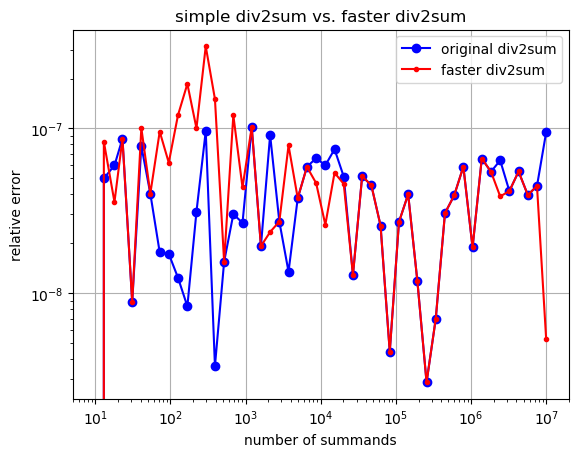

In [31]:
# Sum x[first:last].  This function works, but is a little slower than we would like.
function div2sum(x, first=firstindex(x), last=lastindex(x))
    n = last - first + 1;
    if n < 2
        s = zero(eltype(x))
        for i = first:last
            s += x[i]
        end
        return s
    else
        mid = (first + last) ÷ 2 # find middle as (first+last)/2, rounding down
        return div2sum(x, first, mid) + div2sum(x, mid+1, last)
    end
end

# Make it faster by enlarging the base case:
function div2sum_faster(x, first=firstindex(x), last=lastindex(x))
    n = last - first + 1;
    if n < 200
        s = zero(eltype(x))
        for i = first:last
            s += x[i]
        end
        return s
    else
        mid = (first + last) ÷ 2 # find middle as (first+last)/2, rounding down
        return div2sum_faster(x, first, mid) + div2sum_faster(x, mid+1, last)
    end
end

# check its accuracy for a set logarithmically spaced n's.  Since div2sum is slow,
# we won't go to very large n or use too many points
N = round.(Int, 10 .^ range(1,7,length=50)) # 50 points from 10¹ to 10⁷
err = Float64[]
err_faster = Float64[]
for n in N
    x = rand(Float32, n)
    xdouble = Float64.(x)
    push!(err, abs(div2sum(x) - sum(xdouble)) / abs(sum(xdouble)))
    push!(err_faster, abs(div2sum_faster(x) - sum(xdouble)) / abs(sum(xdouble)))
end

using PyPlot
loglog(N, err, "bo-")
loglog(N, err_faster, "r.-")
title("simple div2sum vs. faster div2sum")
xlabel("number of summands")
ylabel("relative error")
legend(["original div2sum", "faster div2sum"])
grid()

As we can see, the modified version has about the same accuracy.  But is it really faster?

Time it vs. the built-in `sum` (which is also written in Julia), and also write our own looping sum just so that we know exactly what it is doing:

In [32]:
function loopsum(x)
    s = zero(eltype(x))
    for i in eachindex(x)
        s += x[i]
    end
    return s
end

x = rand(Float32, 10^7)
using BenchmarkTools # better benchmarking utilities
@btime div2sum($x)
@btime div2sum_faster($x)
@btime sum($x)
@btime loopsum($x)

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1186


  93.210 ms (0 allocations: 0 bytes)
  10.087 ms (0 allocations: 0 bytes)
  3.293 ms (0 allocations: 0 bytes)
  9.353 ms (0 allocations: 0 bytes)


5.0000995f6

Enlarging the base case made it about **ten times faster** and comparable in speed to `loopsum`, a naive loop.

The built-in `sum` function is still about 2–3 times faster.   It is actually using a [pairwise algorithm too, written in Julia](https://github.com/JuliaLang/julia/blob/38b3c46b0423ab1862f6cee7895a44e3ec397502/base/reduce.jl#L104-L113), but it plays some tricks with the base case to get better CPU utilization.  In particular, it uses [SIMD instructions in either native Julia code](https://github.com/JuliaLang/julia/pull/6928) or via the BLAS `asum` function, depending on the array type.   **Getting the last factor of two in performance is often tricky (and sometimes extremely hard)** and involves extracting every ounce of efficiency from the CPU with low-level tricks.

In this case, it turns out we can catch up with the built-in `sum` just by adding a couple of decorations that turn on [SIMD optimization](http://kristofferc.github.io/post/intrinsics/) (`@simd`) and turn off bounds checking (`@inbounds`):

In [33]:
# Make it faster by enlarging the base case:
function div2sum_evenfaster(x, first=firstindex(x), last=lastindex(x))
    n = last - first + 1;
    if n < 200
        s = zero(eltype(x))
        @simd for i = first:last
            @inbounds s += x[i]
        end
        return s
    else
        mid = (first + last) ÷ 2 # find middle as (first+last)/2, rounding down
        return div2sum_evenfaster(x, first, mid) + div2sum_evenfaster(x, mid+1, last)
    end
end

@btime div2sum_evenfaster($x)

  3.893 ms (0 allocations: 0 bytes)


5.000501f6

We are now a lot closer to the 3.3ms of the built-in `sum` function.  (We can do a bit better by tuning the base-case size.)